<a href="https://colab.research.google.com/github/MarcioSantoos/tcc_resnet/blob/main/tcc_resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# SETUP

import numpy as np
import keras
from keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow import data as tf_data


# TENSORFLOW MODEL

In [ ]:
batch_size = 10
IMG_SIZE = (224, 224)

In [ ]:

train_dataset = tf.keras.utils.image_dataset_from_directory(
  '/content/drive/MyDrive/TCC/Data/train',
  shuffle=True,
  seed=123,
  image_size=IMG_SIZE,
  batch_size=batch_size)


validation_dataset = tf.keras.utils.image_dataset_from_directory(
  '/content/drive/MyDrive/TCC/Data/val',
  shuffle=True,
  seed=123,
  image_size=IMG_SIZE,
  batch_size=batch_size)

test_dataset = tf.keras.utils.image_dataset_from_directory(
  '/content/drive/MyDrive/TCC/Data/test',
  shuffle=True,
  seed=1234,
  image_size=IMG_SIZE,
  batch_size=batch_size)

In [ ]:
class_names = train_dataset.class_names
print(class_names)

['comercial', 'residencial']


In [ ]:
# pré-busca em buffer para carregar imagens do disco sem que a E/S se torne um bloqueio

AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
val_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
# camada para aplicar rotacao e inversao horizontal/vertical
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomTranslation(0.2, 0.2),
])

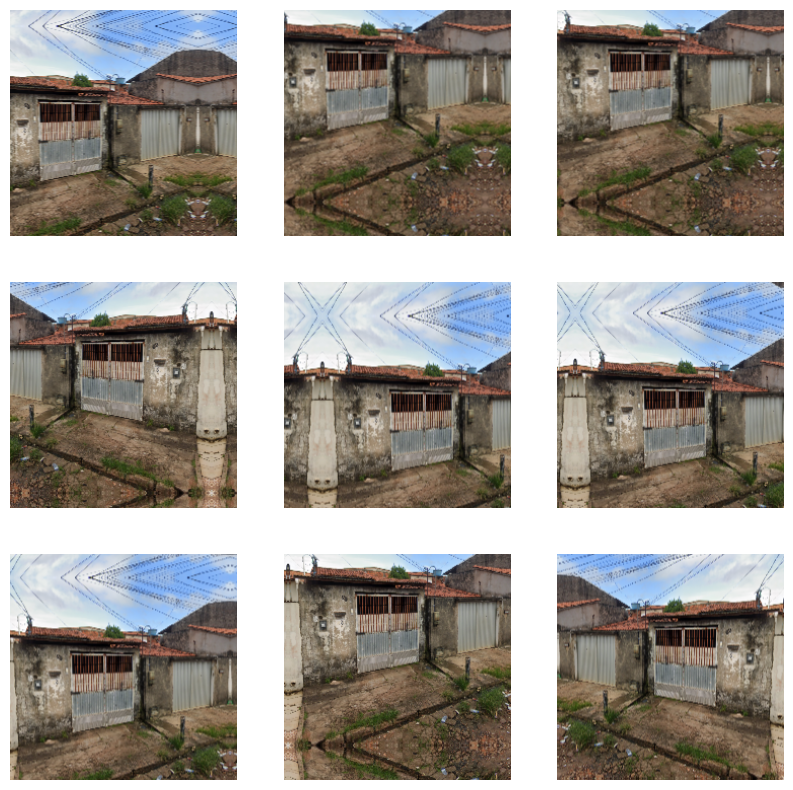

In [ ]:
# plot das imagens com as modificacoes

for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

#plt.savefig("/content/drive/MyDrive/TCC/Data/output_augmentation_.jpg")


In [ ]:
# função de pré-processamento específica para a arquitetura ResNet50, ao contrário de alguns outros modelos, espera que os canais de cor sejam organizados como BGR (Blue-Green-Red) em vez de RGB.
#preprocess_input = tf.keras.applications.resnet50.preprocess_input

In [ ]:
# cria o modelo base a partir do modelo pré-treinado do ResNet50
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

In [ ]:
# processa as imagens no image_batch e extrai features em vez de fazer a classificação final, O resultado (feature_batch) contém representações numéricas das imagens (também chamadas de embeddings).
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(10, 7, 7, 2048)


In [ ]:
# O congelamento (definindo layer.trainable = False) evita que os pesos em uma determinada camada sejam atualizados durante o treinamento
base_model.trainable = False

In [ ]:
# architeture of base_model
base_model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16            │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_16[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
# reduz um mapa de características 3D (altura, largura, canais) para um vetor 1D (apenas canais). Isso reduz a complexidade e prepara os dados para camadas densas.
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(10, 2048)


In [ ]:
# aplica uma camada tf.keras.layers.Dense para converter esses recursos em uma única previsão por imagem. Essa previsão será tratada como um "logit"
#prediction_layer = tf.keras.layers.Dense(1)
#prediction_batch = prediction_layer(feature_batch_average)
#print(prediction_batch.shape)

In [ ]:
# Definição do modelo
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)  # Aplicação de Data Augmentation
x = tf.keras.applications.resnet50.preprocess_input(x)  # Pré-processamento para ResNet

x = base_model(x, training=False)  # Passa pela ResNet sem atualização de pesos
x = global_average_layer(x)
x = tf.keras.layers.Dense(64, kernel_regularizer=tf.keras.regularizers.l2(0.01))(x) # Regularização para evitar overfitting
x = tf.keras.layers.Dropout(0.3)(x)  # Regularização para evitar overfitting
outputs = tf.keras.layers.Dense(1, )(x)  # Camada final para classificação binária
# Criando o modelo final
model = tf.keras.Model(inputs, outputs)

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor= 'val_accuracy' , patience= 10 , restore_best_weights= False )
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='best_model_checkpoint.keras', monitor='val_accuracy', save_best_only=True, mode='max')

In [ ]:
# compila o modelo, definindo o otimizador, a função de perda e as métricas.
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                      tf.keras.metrics.AUC(name='auc')])

In [ ]:
model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_17            │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_5 (Sequential) │ (None, 224, 224, 3)    │              0 │ input_layer_17[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_15 (GetItem)     │ (None, 224, 224)       │              0 │ sequential_5[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_16 (GetItem)     │ (None, 224, 224)       │              0 │ sequential_5[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_17 (GetItem)     │ (None, 224, 224)       │              0 │ sequential_5[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack_5 (Stack)           │ (None, 224, 224, 3)    │              0 │ get_item_15[0][0],     │
│                           │                        │                │ get_item_16[0][0],     │
│                           │                        │                │ get_item_17[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_5 (Add)               │ (None, 224, 224, 3)    │              0 │ stack_5[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resnet50 (Functional)     │ (None, 7, 7, 2048)     │     23,587,712 │ add_5[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 2048)           │              0 │ resnet50[0][0]         │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_5 (Dropout)       │ (None, 2048)           │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 1)              │          2,049 │ dropout_5[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 23,589,761 (89.99 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
len(model.trainable_variables)

2

In [ ]:
initial_epochs = 100

loss0, accuracy0, auc0= model.evaluate(validation_dataset)

2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 697ms/step - accuracy: 0.5667 - auc: 0.5913 - loss: 0.6831


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))
print("initial auc: {:.2f}".format(auc0))

initial loss: 0.68
initial accuracy: 0.60
initial auc: 0.62


In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset,
                    callbacks=[checkpoint, early_stopping]
)
#callbacks=[callback]

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.5193 - auc: 0.5199 - loss: 0.9230 - val_accuracy: 0.5333 - val_auc: 0.7054 - val_loss: 0.6391
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.4318 - auc: 0.4353 - loss: 0.8985 - val_accuracy: 0.6000 - val_auc: 0.6964 - val_loss: 0.6098
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.5159 - auc: 0.5542 - loss: 0.8087 - val_accuracy: 0.6000 - val_auc: 0.6607 - val_loss: 0.5941
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.5090 - auc: 0.5186 - loss: 0.8068 - val_accuracy: 0.5333 - val_auc: 0.6429 - val_loss: 0.5818
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.5393 - auc: 0.6123 - loss: 0.6586 - val_accuracy: 0.5333 - val_auc: 0.6875 - val_loss: 0.5711
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.5196 - auc: 0.5338 - loss: 0.7734 - val_accuracy: 0.5333 - val_auc: 0.6875 - val_loss: 0.5559
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accurac

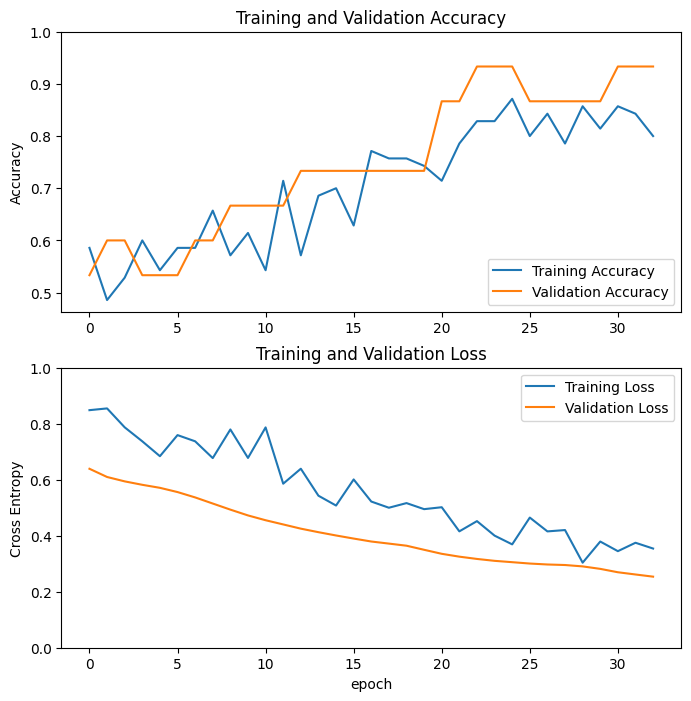

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
#plt.savefig("/content/drive/MyDrive/TCC/Data/output_accuracy_93_3_resnet50.jpg")
plt.show()

# Teste no test_dataset

In [ ]:
loss, accuracy, auc = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

In [ ]:
#model.save('/content/drive/MyDrive/TCC/Data/model_output_accuracy_93_4_com_ft_resnet50.keras')

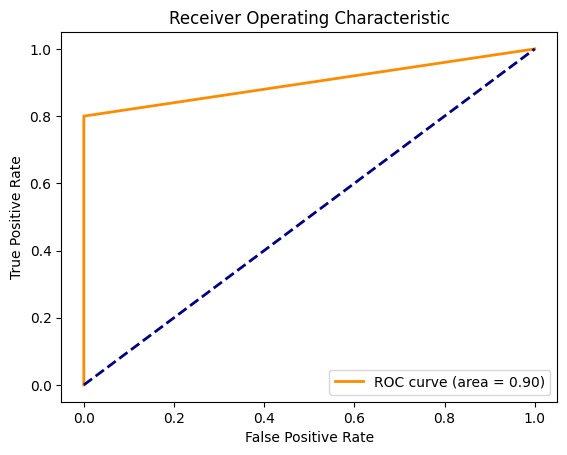

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(label_batch, predictions)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Predictions:
 [0 1 0 0 0 0 1 1 0 1]
Labels:
 [0 1 0 0 1 0 1 1 0 1]


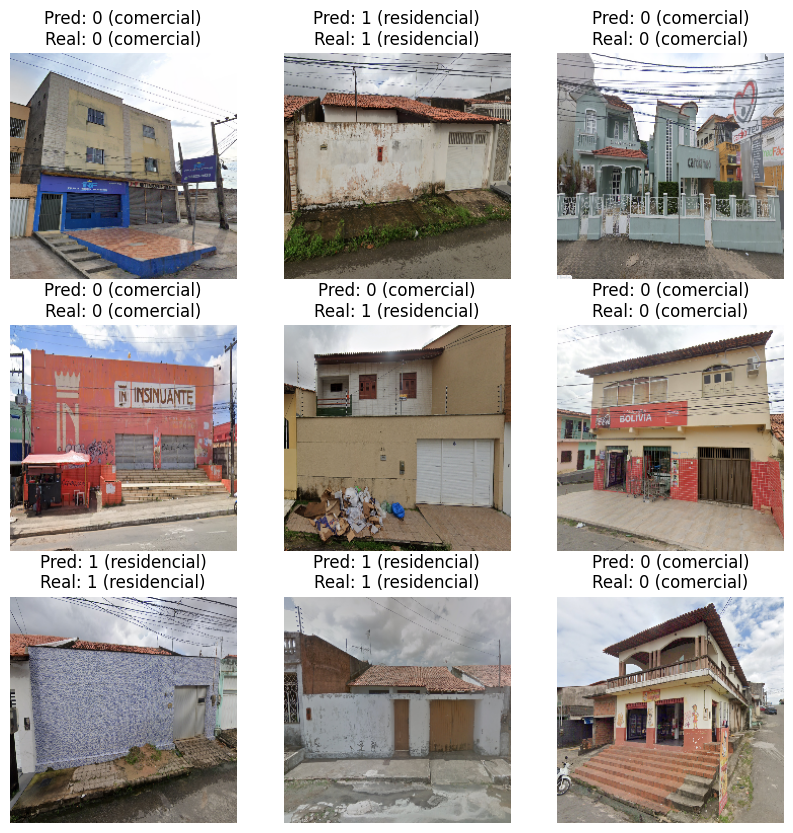

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Recupera um lote de imagens do conjunto de testes
image_batch, label_batch = test_dataset.as_numpy_iterator().next()

# Faz previsões com o modelo
predictions = model.predict_on_batch(image_batch).flatten()

# Aplica a função sigmoid para converter logits em probabilidades
predictions = tf.nn.sigmoid(predictions)

# Define a classe com base no limiar de 0.5
predictions = tf.where(predictions < 0.5, 0, 1).numpy()  # Converte para array NumPy

# Obtém os nomes das classes diretamente do dataset (caso tenha sido carregado com `image_dataset_from_directory`)
class_names = test_dataset.class_names  # Obtém os nomes das classes reais

# Exibe previsões e rótulos verdadeiros
print("Predictions:\n", predictions)
print("Labels:\n", label_batch)

# Plota as imagens com os rótulos preditos e reais
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))

    predicted_index = predictions[i]
    true_index = label_batch[i]

    predicted_class = class_names[predicted_index]  # Nome da classe prevista
    true_class = class_names[true_index]  # Nome da classe real

    plt.title(f"Pred: {predicted_index} ({predicted_class})\nReal: {true_index} ({true_class})")
    plt.axis("off")

plt.show()

#plt.savefig("/content/drive/MyDrive/TCC/Data/predict_output_accuracy_93_3_resnet50.jpg")


# Matriz de confusão e outras metricas

Acurácia: 0.90
Precisão: 1.00
Recall: 0.83
F1-Score: 0.91
Matriz de Confusão:
[[4 0]
 [1 5]]


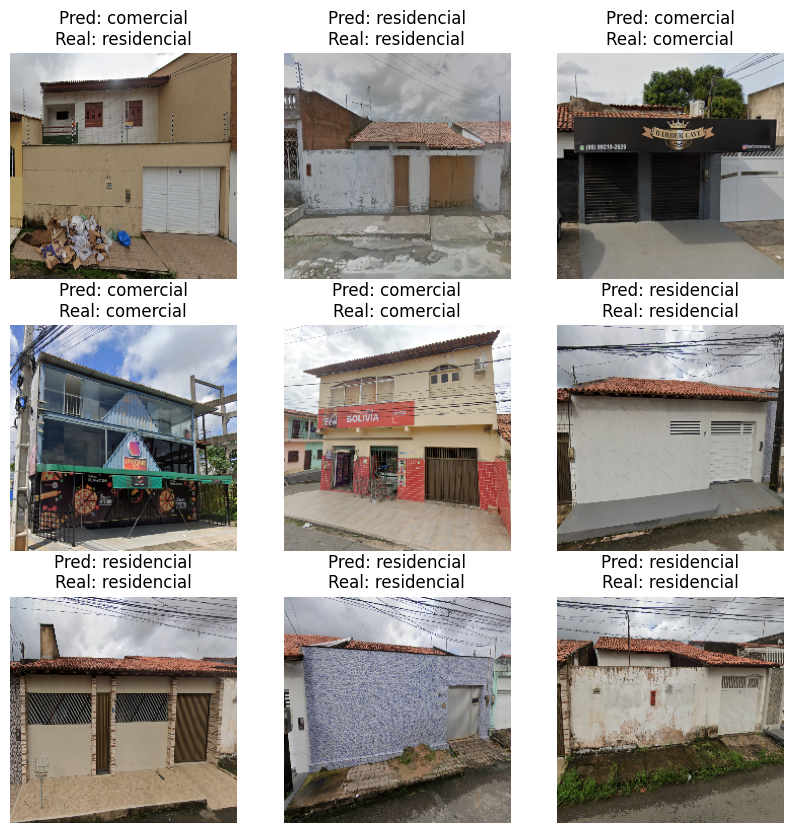

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Supondo que predictions e label_batch já estão definidos
# predictions = tf.nn.sigmoid(predictions)  # Aplicar sigmoid se necessário
# predictions = tf.where(predictions < 0.5, 0, 1)  # Converter para 0 ou 1

# Converter para numpy array (se já não estiver)
#predictions = predictions.numpy()
#label_batch = label_batch.numpy()

# Calcular as métricas
accuracy = accuracy_score(label_batch, predictions)
precision = precision_score(label_batch, predictions)
recall = recall_score(label_batch, predictions)
f1 = f1_score(label_batch, predictions)
conf_matrix = confusion_matrix(label_batch, predictions)

# Exibir as métricas
print(f'Acurácia: {accuracy:.2f}')
print(f'Precisão: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-Score: {f1:.2f}')
print('Matriz de Confusão:')
print(conf_matrix)

# Plotar as imagens com as previsões
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(f'Pred: {class_names[predictions[i]]}\nReal: {class_names[label_batch[i]]}')
    plt.axis("off")
plt.show()